Transformer Forecasting

1. Install Dependencies

In [18]:
!pip install --upgrade neuralforecast
!pip install neuralforecast pytorch-lightning
!pip install neuralforecast neuralforecast[timesnet] transformers
!pip install neuralforecast pandas scikit-learn


2. Import Libraries

In [1]:

import os
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# NeuralForecast imports
from neuralforecast import NeuralForecast
from neuralforecast.models import TimesNet, Informer
from neuralforecast.losses.pytorch import MAE

c:\Users\rebek\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


3. Use TimesNet and Informer model 

In [ ]:

# ==== GPU SETTINGS ====
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
devices = 1

# ==== LOAD DATA ====
df = pd.read_csv('../dataset/combined_with_cluster_feature.csv')
df['time'] = pd.to_datetime(df['time'])

# Separate numeric & non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.drop('time', errors='ignore')

# ==== RESAMPLE ====
df_num = df.set_index('time')[numeric_cols] \
           .resample('2T') \
           .mean() \
           .interpolate(method='linear') \
           .ffill().bfill()

df_nonnum = df.set_index('time')[non_numeric_cols] \
              .resample('2T') \
              .ffill()

# Merge back and reset index
df = pd.concat([df_num, df_nonnum], axis=1).reset_index()

# ==== TARGETS ====
targets = ['rnti_count', 'rb_down', 'rb_up', 'down', 'up']
results = []

# ==== TRAIN & EVALUATE ====
for target in targets:
    print(f"\n=== Training models for target: {target} ===")

    # Format for NeuralForecast
    df_nf = pd.DataFrame({
        'unique_id': 'bs1',
        'ds': df['time'],
        'y': df[target]
    })

    # Ensure no NaNs in y
    df_nf['y'] = df_nf['y'].interpolate(method='linear').ffill().bfill()

    # Train/test split
    train_size = int(len(df_nf) * 0.8)
    df_train = df_nf.iloc[:train_size]
    df_test = df_nf.iloc[train_size:]
    #h = len(df_test)
    h=10

    # Models
    model_tn = TimesNet(
        h=h, input_size=12, loss=MAE(),
        max_steps=5, batch_size=16,
        accelerator=accelerator, devices=devices
    )

    model_if = Informer(
        h=h, input_size=12, hidden_size=64, n_head=4, factor=3,
        encoder_layers=1, decoder_layers=1, dropout=0.05,
        distil=True, loss=MAE(),
        max_steps=5, batch_size=16,
        accelerator=accelerator, devices=devices
    )

    # Train
    nf = NeuralForecast(models=[model_tn, model_if], freq='2T')
    nf.fit(df_train)

    # Predict
    pred_df = nf.predict()
    pred_df['ds'] = pd.to_datetime(pred_df['ds'])

    # Merge predictions with test set (ensuring alignment)
    merged = pd.merge(df_test, pred_df, on=['unique_id', 'ds'], how='inner')

    if merged.empty:
        print(f"No overlap for {target} — check freq or timestamp alignment.")
        continue

    # Evaluation
    mae_tn = mean_absolute_error(merged['y'], merged['TimesNet'])
    rmse_tn = np.sqrt(mean_squared_error(merged['y'], merged['TimesNet']))

    mae_if = mean_absolute_error(merged['y'], merged['Informer'])
    rmse_if = np.sqrt(mean_squared_error(merged['y'], merged['Informer']))

    results.append({
        'Target': target,
        'TimesNet_MAE': mae_tn,
        'TimesNet_RMSE': rmse_tn,
        'Informer_MAE': mae_if,
        'Informer_RMSE': rmse_if
    })

    print(f"{target} - TimesNet: MAE={mae_tn:.2f}, RMSE={rmse_tn:.2f}")
    print(f"{target} - Informer: MAE={mae_if:.2f}, RMSE={rmse_if:.2f}")

# ==== RESULTS TABLE ====
results_df = pd.DataFrame(results)
print("\n=== Final Results Across All Targets ===")
print(results_df)


C:\Users\rebek\AppData\Local\Temp\ipykernel_50540\3370867793.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('2T') \
C:\Users\rebek\AppData\Local\Temp\ipykernel_50540\3370867793.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('2T') \
Seed set to 1
Seed set to 1
c:\Users\rebek\anaconda3\Lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/s


=== Training models for target: rnti_count ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 234    | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.752    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
c:\Users\rebek\anaconda3\Lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 192    | train
4 | dec_embedding | DataEmbedding | 192    | train
5 | encoder       | TransEncoder  | 21.2 K | train
6 | decoder       | TransDecoder  | 38.0 K | train
--------------------------------------------------------
59.6 K    Trainable params
0         Non-trainable params
59.6 K    Total par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
Seed set to 1
c:\Users\rebek\anaconda3\Lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 234    | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0     

rnti_count - TimesNet: MAE=0.20, RMSE=0.21
rnti_count - Informer: MAE=5737.73, RMSE=5737.73

=== Training models for target: rb_down ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 192    | train
4 | dec_embedding | DataEmbedding | 192    | train
5 | encoder       | TransEncoder  | 21.2 K | train
6 | decoder       | TransDecoder  | 38.0 K | train
--------------------------------------------------------
59.6 K    Trainable params
0         Non-trainable params
59.6 K    Total params
0.239     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
Seed set to 1
c:\Users\rebek\anaconda3\Lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 234    | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0     

rb_down - TimesNet: MAE=0.00, RMSE=0.00
rb_down - Informer: MAE=0.29, RMSE=0.33

=== Training models for target: rb_up ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 192    | train
4 | dec_embedding | DataEmbedding | 192    | train
5 | encoder       | TransEncoder  | 21.2 K | train
6 | decoder       | TransDecoder  | 38.0 K | train
--------------------------------------------------------
59.6 K    Trainable params
0         Non-trainable params
59.6 K    Total params
0.239     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
Seed set to 1
c:\Users\rebek\anaconda3\Lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 234    | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0     

rb_up - TimesNet: MAE=0.00, RMSE=0.00
rb_up - Informer: MAE=0.29, RMSE=0.33

=== Training models for target: down ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 192    | train
4 | dec_embedding | DataEmbedding | 192    | train
5 | encoder       | TransEncoder  | 21.2 K | train
6 | decoder       | TransDecoder  | 38.0 K | train
--------------------------------------------------------
59.6 K    Trainable params
0         Non-trainable params
59.6 K    Total params
0.239     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
Seed set to 1
c:\Users\rebek\anaconda3\Lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 234    | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0     

down - TimesNet: MAE=4616.25, RMSE=4771.36
down - Informer: MAE=67017541.07, RMSE=67017541.08

=== Training models for target: up ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 192    | train
4 | dec_embedding | DataEmbedding | 192    | train
5 | encoder       | TransEncoder  | 21.2 K | train
6 | decoder       | TransDecoder  | 38.0 K | train
--------------------------------------------------------
59.6 K    Trainable params
0         Non-trainable params
59.6 K    Total params
0.239     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\rebek\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

up - TimesNet: MAE=612.60, RMSE=668.41
up - Informer: MAE=15136743.60, RMSE=15136743.60

=== Final Results Across All Targets ===
       Target  TimesNet_MAE  TimesNet_RMSE  Informer_MAE  Informer_RMSE
0  rnti_count  2.017256e-01   2.086089e-01  5.737732e+03   5.737732e+03
1     rb_down  1.607511e-07   1.790084e-07  2.880206e-01   3.331137e-01
2       rb_up  1.969040e-07   2.533938e-07  2.879445e-01   3.325104e-01
3        down  4.616250e+03   4.771360e+03  6.701754e+07   6.701754e+07
4          up  6.126050e+02   6.684116e+02  1.513674e+07   1.513674e+07


Visualization

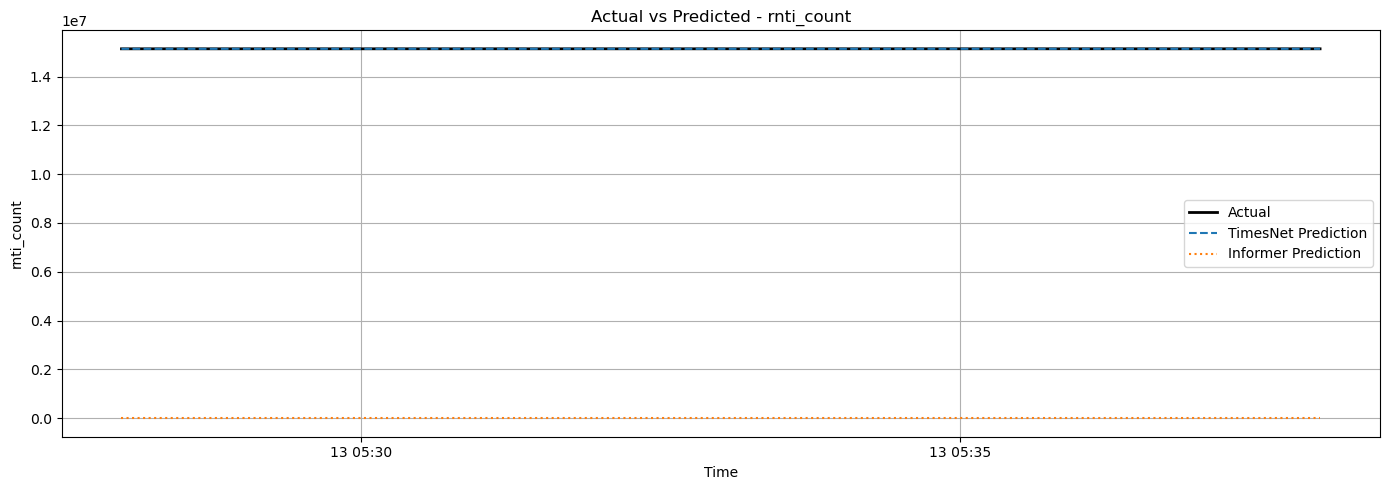

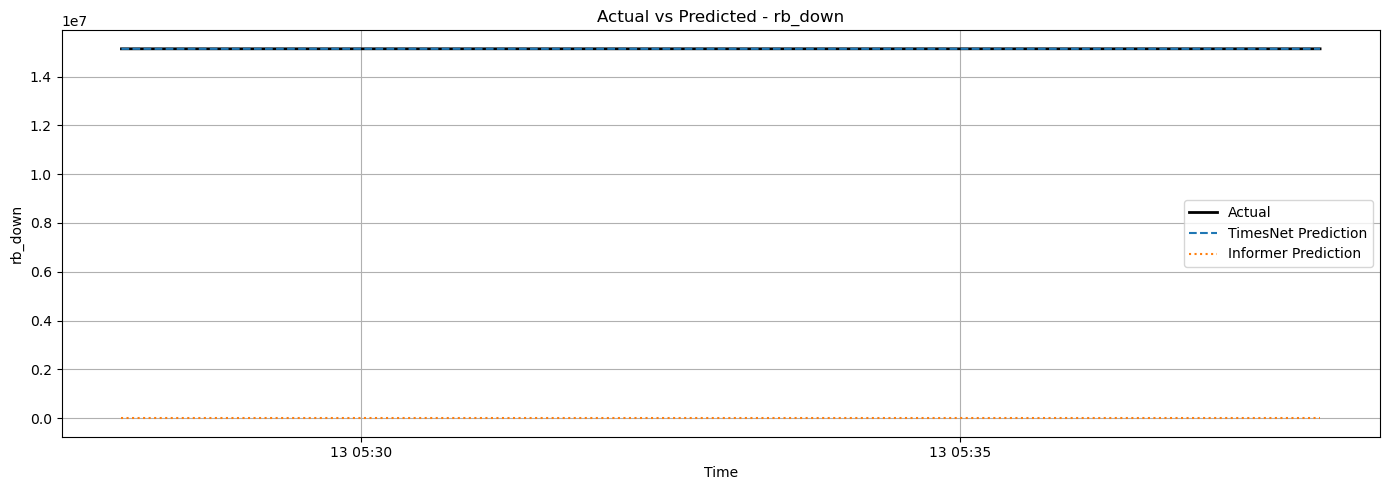

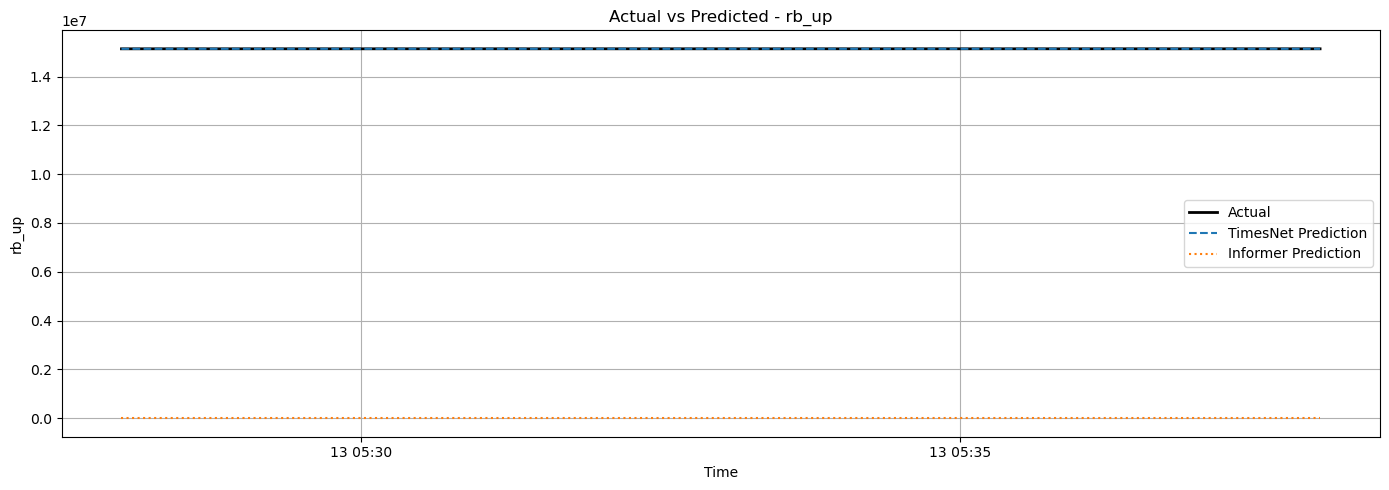

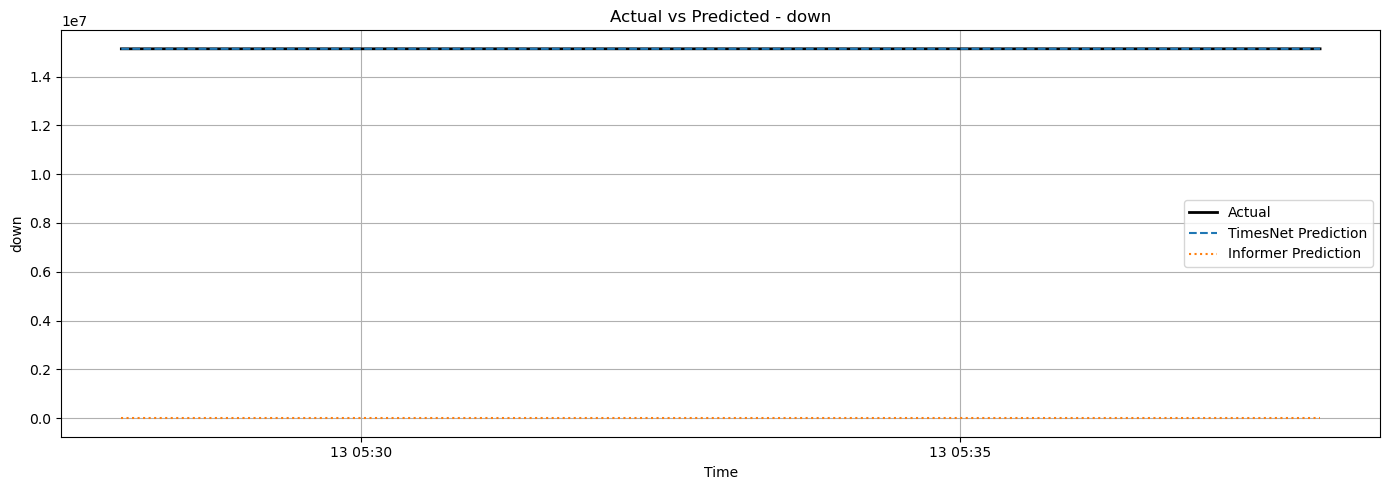

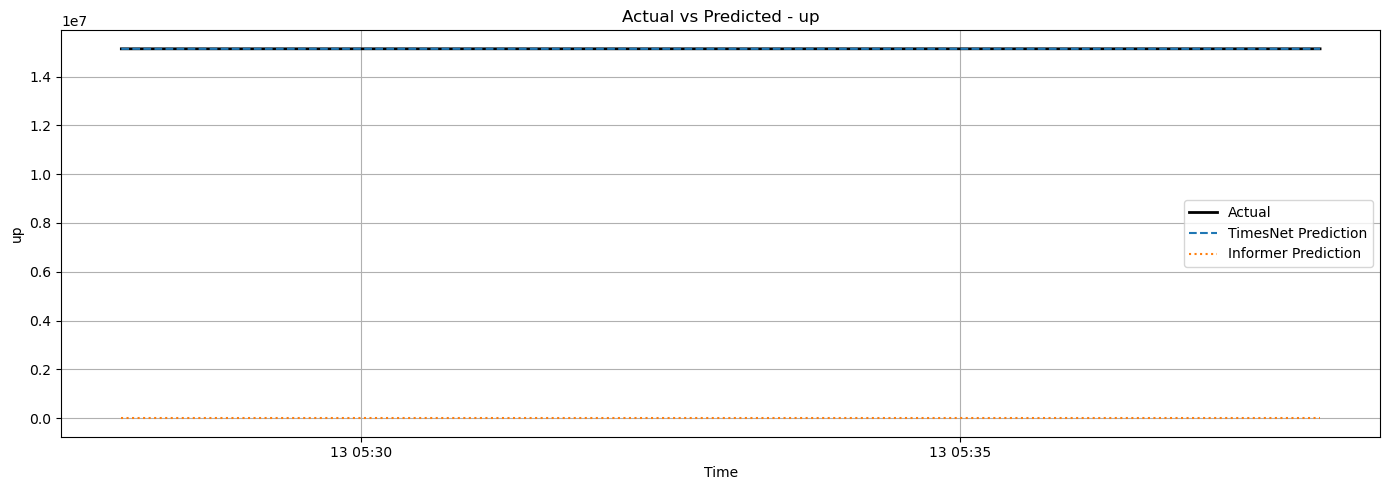

In [4]:
import matplotlib.pyplot as plt

# Loop through each target and plot Actual vs Predicted for both models
for target in targets:
    plt.figure(figsize=(14, 5))

    # Filter the merged DataFrame for the current target
    merged_target = merged[merged['Target'] == target] if 'Target' in merged.columns else merged

    # Plot Actual
    plt.plot(merged_target['ds'], merged_target['y'], label='Actual', color='black', linewidth=2)

    # Plot TimesNet Predictions
    if 'TimesNet' in merged_target.columns:
        plt.plot(merged_target['ds'], merged_target['TimesNet'], label='TimesNet Prediction', linestyle='--')

    # Plot Informer Predictions
    if 'Informer' in merged_target.columns:
        plt.plot(merged_target['ds'], merged_target['Informer'], label='Informer Prediction', linestyle=':')

    plt.title(f"Actual vs Predicted - {target}")
    plt.xlabel("Time")
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
